# Introduction

This project aims to explore deep learning using quarterly GDP changes in Singapore
<br> Dataset extracted from: https://data.gov.sg/dataset/gross-domestic-product-in-chained-2015-dollars-year-on-year-growth-rate-quarterly
<br> Licence: Singapore Open Data Licence
<br> Information and inspiration taken from: https://github.com/lisaong/stackup-workshops/tree/master/learn-history

#Importing Data

In [0]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

import io
import requests
import zipfile

import pandas as pd

from sklearn.model_selection import train_test_split
import tensorflow as tf

import pickle
plt.style.use('seaborn-whitegrid')

In [0]:
url = 'https://data.gov.sg/dataset/92bcfcdf-cbb2-4497-a855-5aad9cf95cad/download'
headers = {
    'User-Agent': 'Mozilla/5.0',
}
response = requests.get(url, headers=headers)
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall()

In [0]:
z.printdir()

File Name                                             Modified             Size
metadata-gross-domestic-product-in-chained-2015-dollars-year-on-year-growth-rate-quarterly.txt 2020-06-13 05:24:02         2520
gross-domestic-product-in-chained-2015-dollars-year-on-year-growth-rate-quarterly.csv 2020-06-13 05:24:02         7647


In [0]:
df=pd.read_csv('gross-domestic-product-in-chained-2015-dollars-year-on-year-growth-rate-quarterly.csv',parse_dates=True, index_col=0)

# Data Visualization

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 177 entries, 1976-01-01 to 2020-01-01
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   level_1  177 non-null    object 
 1   value    177 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.1+ KB


In [0]:
df.head()

,level_1,value
quarter,,
1976-01-01,GDP In Chained (2015) Dollars,8.2
1976-04-01,GDP In Chained (2015) Dollars,7.4
1976-07-01,GDP In Chained (2015) Dollars,7.2
1976-10-01,GDP In Chained (2015) Dollars,7.0
1977-01-01,GDP In Chained (2015) Dollars,6.2


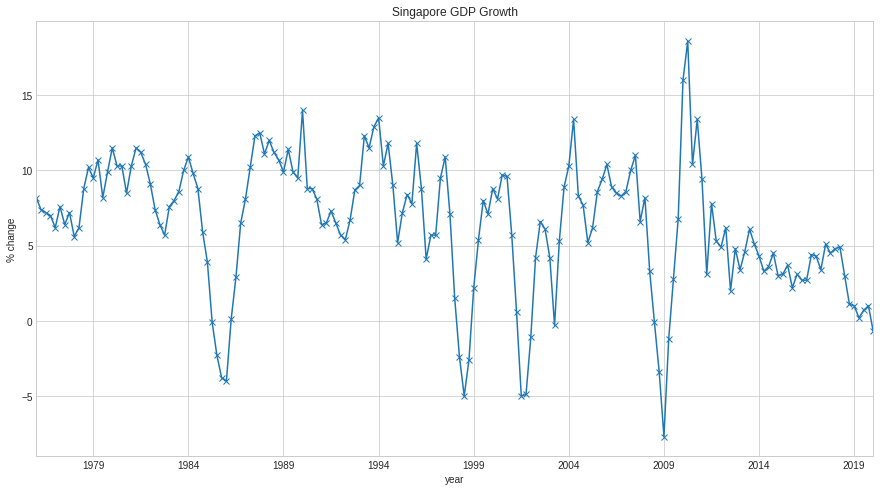

In [0]:
df['value'].plot(figsize=(15, 8), marker='x', title='Singapore GDP Growth')
plt.xlabel('year')
plt.ylabel('% change')
plt.show()

In [0]:
df['value'].describe()

count    177.000000
mean       6.450282
std        4.367833
min       -7.700000
25%        4.200000
50%        7.100000
75%        9.500000
max       18.600000
Name: value, dtype: float64

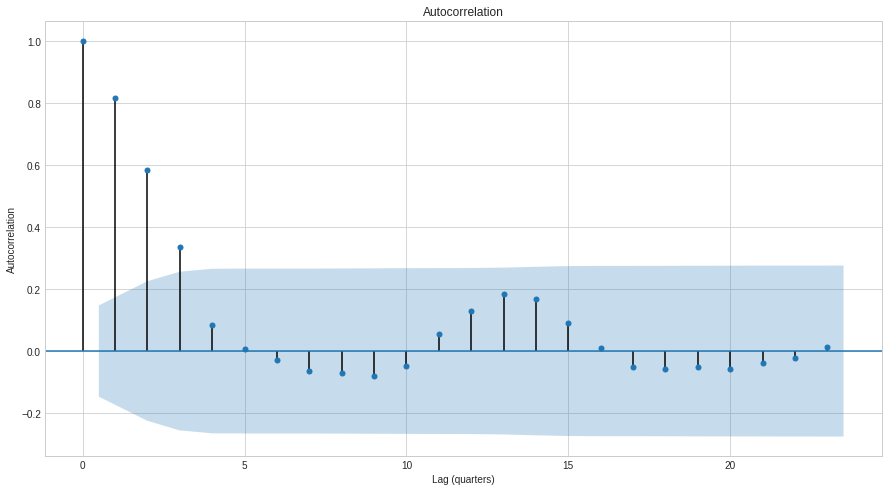

In [0]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_acf(df['value'], ax=ax)
ax.set_ylabel('Autocorrelation')
ax.set_xlabel('Lag (quarters)')
plt.show()

Based on the autocorrelation graph we can tell that predictability decreases as time lag increases 
<br>ie its better to use previous day data to predict today's data vs data from 2 days ago

In [0]:
window_size = 3

In a time series prediction, we are using past historical figures as 'features'. This modelling is simply a more complicated version of calculating simple moving averages.

In [0]:
new_columns = [df['value'].shift(-i) for i in range(window_size+1)]
new_column_names = [f't+{i}' for i in range(window_size+1)]

df_windowed = pd.concat(new_columns, axis=1)
df_windowed.columns = new_column_names
df_windowed

,t+0,t+1,t+2,t+3
quarter,,,,
1976-01-01,8.2,7.4,7.2,7.0
1976-04-01,7.4,7.2,7.0,6.2
1976-07-01,7.2,7.0,6.2,7.6
1976-10-01,7.0,6.2,7.6,6.4
1977-01-01,6.2,7.6,6.4,7.2
...,...,...,...,...
2019-01-01,1.0,0.2,0.7,1.0
2019-04-01,0.2,0.7,1.0,-0.7
2019-07-01,0.7,1.0,-0.7,NaN


In [0]:
df_windowed.dropna(inplace=True)

In [0]:
df_windowed.columns

Index(['t+0', 't+1', 't+2', 't+3'], dtype='object')

In [0]:
y = df_windowed['t+3']
X = df_windowed.drop(columns=['t+3'])
X.shape, y.shape

((174, 3), (174,))

# Modelling

In [0]:
from tensorflow.keras import layers
model = tf.keras.Sequential()
model.add(layers.Dense(16, input_shape=(3,), activation='relu'))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 16)                64        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((130, 3), (44, 3), (130,), (44,))

In [0]:
model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train, batch_size=16, epochs=50,
                    validation_data=(X_test, y_test))

Epoch 1/50
9/9 [==============================] - 0s 14ms/step - loss: 63.8960 - mae: 7.4473 - val_loss: 30.7413 - val_mae: 4.3379
Epoch 2/50
9/9 [==============================] - 0s 6ms/step - loss: 54.8600 - mae: 6.8969 - val_loss: 26.4821 - val_mae: 3.9428
Epoch 3/50
9/9 [==============================] - 0s 6ms/step - loss: 46.2051 - mae: 6.3195 - val_loss: 22.6909 - val_mae: 3.5571
Epoch 4/50
9/9 [==============================] - 0s 7ms/step - loss: 39.1169 - mae: 5.8143 - val_loss: 19.3936 - val_mae: 3.2296
Epoch 5/50
9/9 [==============================] - 0s 7ms/step - loss: 32.6092 - mae: 5.2851 - val_loss: 16.7166 - val_mae: 2.9472
Epoch 6/50
9/9 [==============================] - 0s 6ms/step - loss: 27.5828 - mae: 4.8147 - val_loss: 14.5704 - val_mae: 2.6916
Epoch 7/50
9/9 [==============================] - 0s 6ms/step - loss: 23.3864 - mae: 4.3865 - val_loss: 12.8288 - val_mae: 2.4472
Epoch 8/50
9/9 [==============================] - 0s 6ms/step - loss: 19.8210 - mae: 3.99

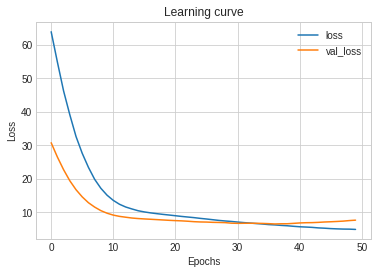

In [0]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [0]:
y_pred = model.predict(X)
df_pred = pd.DataFrame(index=X.index, data={'predictions': y_pred.ravel()})

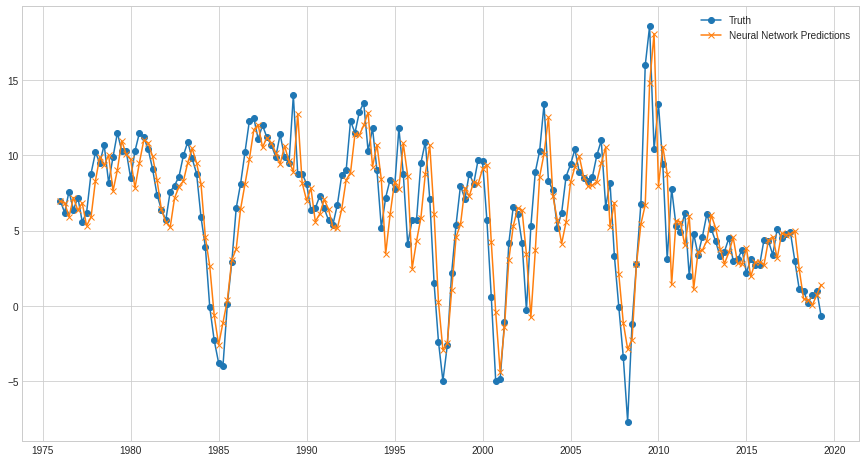

In [0]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(y, label='Truth', marker='o')
ax.plot(df_pred, label='Neural Network Predictions', marker='x')
ax.legend()
plt.show()

# Tweaking / Exploration

We will now try to adjust various hyperparameters and see the effects on the Artificial Neural Network 

* activation function
* batch_size
* epoch size
* optimizer
* neurons per layer
* layers
* window_size

## Activation Function

In [0]:
activation_fn = ['sigmoid','elu','selu']

Epoch 1/50
9/9 [==============================] - 0s 13ms/step - loss: 60.7270 - mae: 7.2384 - val_loss: 31.7963 - val_mae: 4.2117
Epoch 2/50
9/9 [==============================] - 0s 6ms/step - loss: 59.2192 - mae: 7.1498 - val_loss: 30.9613 - val_mae: 4.1192
Epoch 3/50
9/9 [==============================] - 0s 6ms/step - loss: 57.7319 - mae: 7.0583 - val_loss: 30.1848 - val_mae: 4.0320
Epoch 4/50
9/9 [==============================] - 0s 6ms/step - loss: 56.3099 - mae: 6.9699 - val_loss: 29.4229 - val_mae: 3.9443
Epoch 5/50
9/9 [==============================] - 0s 6ms/step - loss: 54.9496 - mae: 6.8841 - val_loss: 28.7009 - val_mae: 3.8628
Epoch 6/50
9/9 [==============================] - 0s 6ms/step - loss: 53.6473 - mae: 6.8029 - val_loss: 27.9797 - val_mae: 3.7811
Epoch 7/50
9/9 [==============================] - 0s 6ms/step - loss: 52.3756 - mae: 6.7202 - val_loss: 27.2619 - val_mae: 3.7013
Epoch 8/50
9/9 [==============================] - 0s 6ms/step - loss: 51.1397 - mae: 6.63

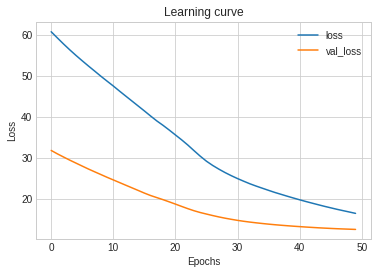

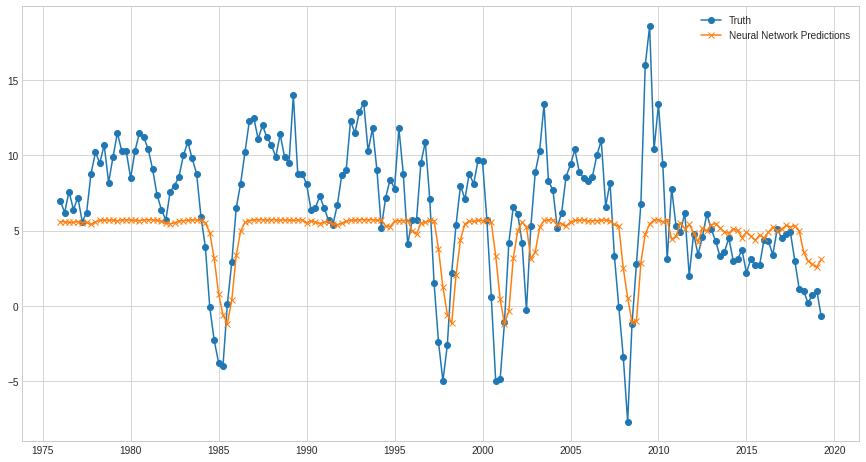

Epoch 1/50
9/9 [==============================] - 0s 13ms/step - loss: 30.6756 - mae: 4.9649 - val_loss: 21.1380 - val_mae: 2.7701
Epoch 2/50
9/9 [==============================] - 0s 7ms/step - loss: 24.9579 - mae: 4.3545 - val_loss: 19.0888 - val_mae: 2.5783
Epoch 3/50
9/9 [==============================] - 0s 6ms/step - loss: 20.6904 - mae: 3.7874 - val_loss: 17.8077 - val_mae: 2.4457
Epoch 4/50
9/9 [==============================] - 0s 6ms/step - loss: 17.9879 - mae: 3.4077 - val_loss: 17.0570 - val_mae: 2.3577
Epoch 5/50
9/9 [==============================] - 0s 6ms/step - loss: 16.4579 - mae: 3.1325 - val_loss: 16.6901 - val_mae: 2.3137
Epoch 6/50
9/9 [==============================] - 0s 6ms/step - loss: 15.4970 - mae: 2.9887 - val_loss: 16.3210 - val_mae: 2.2984
Epoch 7/50
9/9 [==============================] - 0s 6ms/step - loss: 14.8365 - mae: 2.9084 - val_loss: 15.9250 - val_mae: 2.2712
Epoch 8/50
9/9 [==============================] - 0s 6ms/step - loss: 14.3226 - mae: 2.85

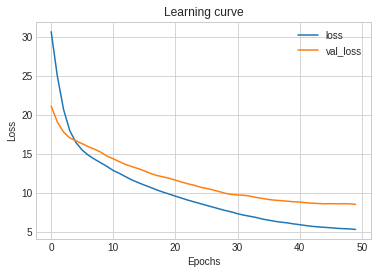

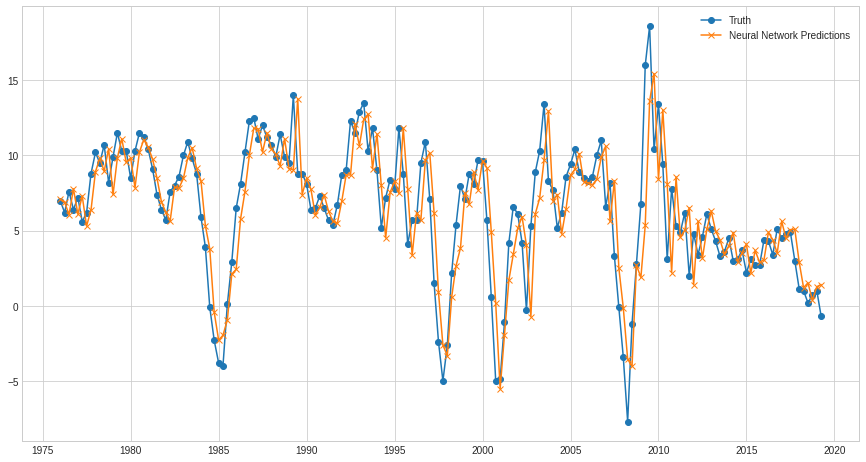

Epoch 1/50
9/9 [==============================] - 0s 13ms/step - loss: 47.6828 - mae: 6.4575 - val_loss: 23.4793 - val_mae: 3.6128
Epoch 2/50
9/9 [==============================] - 0s 6ms/step - loss: 39.0358 - mae: 5.7608 - val_loss: 19.8220 - val_mae: 3.1770
Epoch 3/50
9/9 [==============================] - 0s 6ms/step - loss: 31.6246 - mae: 5.1203 - val_loss: 17.0514 - val_mae: 2.7725
Epoch 4/50
9/9 [==============================] - 0s 6ms/step - loss: 26.0983 - mae: 4.5500 - val_loss: 15.0982 - val_mae: 2.4176
Epoch 5/50
9/9 [==============================] - 0s 8ms/step - loss: 22.0764 - mae: 4.0593 - val_loss: 13.9291 - val_mae: 2.1902
Epoch 6/50
9/9 [==============================] - 0s 7ms/step - loss: 19.4152 - mae: 3.6925 - val_loss: 13.1965 - val_mae: 2.0513
Epoch 7/50
9/9 [==============================] - 0s 6ms/step - loss: 17.5475 - mae: 3.3917 - val_loss: 12.7459 - val_mae: 2.0109
Epoch 8/50
9/9 [==============================] - 0s 6ms/step - loss: 16.1938 - mae: 3.17

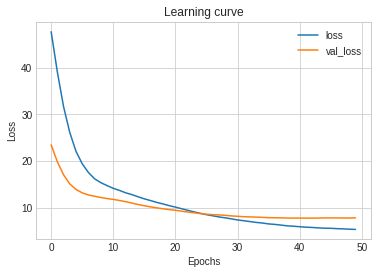

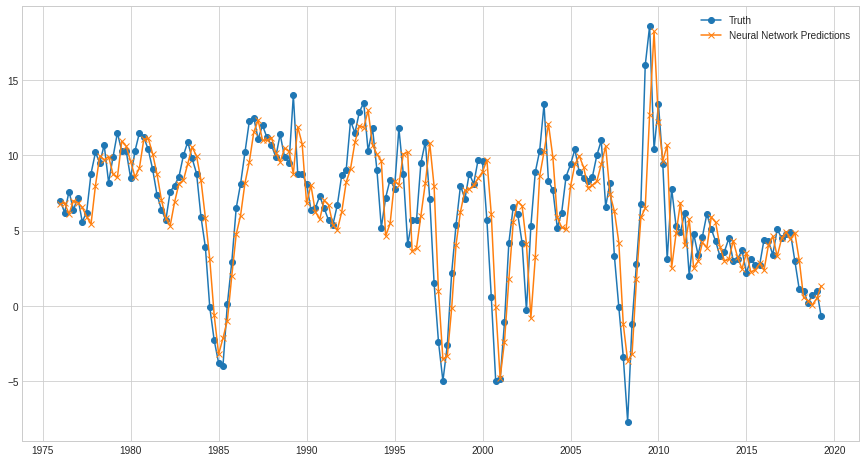

In [0]:
for i in activation_fn:
  model = tf.keras.Sequential()
  model.add(layers.Dense(16, input_shape=(3,), activation=i))
  model.add(layers.Dense(1))
  model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
  history = model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_test, y_test));
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.title('Learning curve')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()
  y_pred = model.predict(X)
  df_pred = pd.DataFrame(index=X.index, data={'predictions': y_pred.ravel()})
  fig, ax = plt.subplots(figsize=(15, 8))
  ax.plot(y, label='Truth', marker='o')
  ax.plot(df_pred, label='Neural Network Predictions', marker='x')
  ax.legend()
  plt.show()